In [1]:
pip install yahoo_fin

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import time as tm
import datetime as dt

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf

2022-10-20 08:51:24.822631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [6]:
# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [7]:
# Graphics library
import matplotlib.pyplot as plt

In [8]:
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'TUPRS.IS'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [9]:
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [10]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

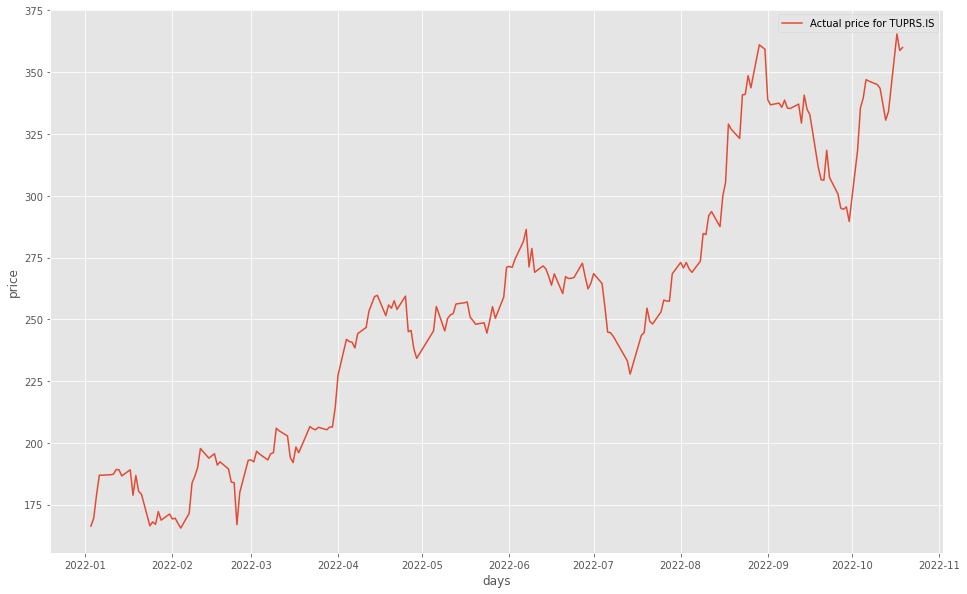

In [11]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [12]:
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [13]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [14]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [15]:
from keras.models import Sequential

In [16]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

2022-10-20 08:51:35.134321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/80
94/94 [==============================] - 3s 5ms/step - loss: 0.0081
Epoch 2/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 3/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 4/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 5/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 6/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 7/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 8/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 9/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 10/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 11/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 12/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/80
94/94 [==============================

94/94 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 8/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 9/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 10/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 11/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 13/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 14/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 15/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 16/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 17/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 18/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 19/80
94/94 [==============================] - 0

94/94 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 14/80
94/94 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 15/80
94/94 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 16/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 17/80
94/94 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 18/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 19/80
94/94 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 20/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 21/80
94/94 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 22/80
94/94 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 23/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 24/80
94/94 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 25/80
94/94 [==============================] -

In [17]:
if bool(predictions) == True and len(predictions) > 0:
    predictions_list = [str(d)+'tl' for d in predictions]
    predictions_str = ','.join(predictions_list)
    message = f'{STOCK} önümüzdeki 3 gün için tahmin ({predictions_str})'
    print(message)

TUPRS.IS önümüzdeki 3 gün için tahmin (362.03tl,366.37tl,357.66tl)
